In [1]:
import os
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import pickle as pkl
import torch
from scipy.sparse import lil_matrix, csr_matrix

import importlib
import src.utils_BERT
from src.performer_pytorch.performer_pytorch import PerformerLM
importlib.reload(src.utils_BERT)
importlib.reload(src.performer_pytorch.performer_pytorch)

<module 'src.performer_pytorch.performer_pytorch' from '/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/src/performer_pytorch/performer_pytorch.py'>

In [2]:
data_dir = '/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/processed_data'
work_dir = '/data/lyx/scCHiP/scATAC/LDA/PBMC_10k'
sc_count_file = os.path.join(data_dir,"10k_PBMC_Multiome_filtered_gene_count.h5ad")
sc_anno_file = os.path.join(data_dir,"MainCelltype.txt")

In [3]:
meta_data = pd.read_table(sc_anno_file, header=None,index_col=0)
meta_data.columns = ["Celltype"]
cell_type = list(set(meta_data.Celltype))
ntopics_list = list(range(len(cell_type), 3*len(cell_type)+1))

In [4]:
data = sc.read_h5ad(sc_count_file)
gene_names = pd.read_table(os.path.join(work_dir,"src/data_BERT/gene2vec_16906_names.txt"),sep="\t",header=None)[0].to_list()
data = data[:,data.var_names.isin(gene_names)].copy()
indices = [index for index, element in enumerate(gene_names) if element in data.var_names] 

sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

data_csr = np.zeros((data.shape[0], len(gene_names)), dtype=np.float32) 
data_csr[:, indices]=np.array(data.X.todense())
data_csr = csr_matrix(data_csr)

In [5]:
label_names, label = np.unique(np.array(meta_data['Celltype']), return_inverse=True)  
# Convert strings categorical to integrate categorical, and label_names[label] can be restored
#store the label dict and label for prediction
# with open('label_names', 'wb') as fp:
#     pkl.dump(label_names, fp)
# with open('label', 'wb') as fp:
#     pkl.dump(label, fp)

class_num = np.unique(label, return_counts=True)[1].tolist()

In [6]:
class_weight = torch.tensor([(1 - (x / sum(class_num))) ** 2 for x in class_num])
label = torch.from_numpy(label)

In [7]:
import gc
# import argparse
import json
import random
import math
import random
from functools import reduce
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report

In [8]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts, CyclicLR
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [9]:
class SCDataset(Dataset):
    def __init__(self, data, label,CLASS,device):
        super().__init__()
        self.data = data
        self.label = label
        self.CLASS = CLASS
        self.device = device

    def __getitem__(self, index):
        rand_start = random.randint(0, self.data.shape[0]-1)
        full_seq = self.data[rand_start].toarray()[0]
        full_seq[full_seq > (self.CLASS - 2)] = self.CLASS - 2
        full_seq = torch.from_numpy(full_seq).long()
        full_seq = torch.cat((full_seq, torch.tensor([0]))).to(self.device)
        seq_label = self.label[rand_start]
        return full_seq, seq_label

    def __len__(self):
        return self.data.shape[0]

class Identity(torch.nn.Module):
    def __init__(self, dropout = 0., h_dim = 128, out_dim = 6,SEQ_LEN=16907):
        super(Identity, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, (1, 200))
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(in_features=SEQ_LEN, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x):
        # print(x.shape)
        x = x[:,None,:,:]
        # print(x.shape)
        x = self.conv1(x)
        x = self.act(x)
        # print(x.shape)
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        # print(x.shape)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        # print(x.shape)
        x = self.fc3(x)
        # print(x.shape)
        return x

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_f1 = -float('inf')
        self.counter = 0

    def __call__(self, val_f1):
        if val_f1 > self.best_f1 + self.min_delta:
            self.best_f1 = val_f1
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience
        
class GeneWiseAttention(nn.Module):
    """轻量型基因位置注意力"""
    def __init__(self, in_dim, seq_len):
        super().__init__()
        self.position_bias = nn.Parameter(torch.randn(seq_len))
        self.channel_scale = nn.Sequential(
            nn.Linear(in_dim, in_dim//4),
            nn.ReLU(),
            nn.Linear(in_dim//4, in_dim)
        )
        
    def forward(self, x):
        """输入形状: [batch, channels, seq_len]"""
        # 通道缩放
        channel_weights = self.channel_scale(x.mean(dim=-1))  # [24,256]
        x = x * channel_weights.unsqueeze(-1)
        
        # 位置偏置
        return x + self.position_bias.view(1,1,-1)  # [24,256,512]


class BioClassifier(nn.Module):
    def __init__(self, seq_len=16907, embed_dim=200, num_classes=6):
        super().__init__()
        
        # 修改后的维度对齐
        self.proj = nn.Linear(200, 256)  # 输入200 → 输出256
        
        # 修正卷积层输入通道
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, padding=1),  # 输入输出均为256
            nn.GELU(),
            nn.LayerNorm([256, seq_len]),  # 保持维度匹配
            
            nn.AdaptiveAvgPool1d(512),
            GeneWiseAttention(256, 512)     # 同步调整输入维度
        )
        
        # 分类器保持原结构
        self.classifier = nn.Sequential(
            nn.Linear(256*512, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.proj(x)        # [24,16907,200] → [24,16907,256]
        x = x.permute(0, 2, 1)  # [24,256,16907] → 正确匹配Conv1d输入格式
        features = self.feature_extractor(x)
        return self.classifier(features.view(features.size(0), -1))

# first train #

In [10]:
SEED = 1
BATCH_SIZE = 24
CLASS = 5+2 #Number of bins.'+2
SEQ_LEN = len(gene_names)+1#gene_num", type=int, default=16906
POS_EMBED_USING = True #'Using Gene2vec encoding or not.'
LEARNING_RATE = 1e-4
EPOCHS = 20
GRADIENT_ACCUMULATION = 60
VALIDATE_EVERY =1
PATIENCE = 10
UNASSIGN_THRES = 0.0
path = "/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/src/data_BERT/panglao_pretrain.pth"
device = torch.device("cpu")

POS_EMBED_USING =True
model_name = "2025_finetune_PBMC_MainCelltype_scBert_0217"
ckpt_dir = os.path.join(work_dir,"scBert_model","scBert_PBMC_10k/")
# world_size = torch.distributed.get_world_size()


In [11]:
len(gene_names)

16906

In [12]:
acc = []
f1 = []
f1w = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
pred_list = pd.Series(['un'] * data_csr.shape[0])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for index_train, index_val in sss.split(data_csr, label):
    data_train, label_train = data_csr[index_train], label[index_train]
    data_val, label_val = data_csr[index_val], label[index_val]
    train_dataset = SCDataset(data_train, label_train,CLASS,device)
    val_dataset = SCDataset(data_val, label_val,CLASS,device)

In [13]:
train_sampler = src.utils_BERT.SimpleSampler(train_dataset)
val_sampler = src.utils_BERT.SimpleSampler(val_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

## run ##

In [14]:
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    gene_weight_file='./src/data_BERT/gene2vec_16906.npy',
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING
)

/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/src/performer_pytorch/performer_pytorch.py:175: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  q, r = torch.qr(unstructured_block.cpu(), some = True)


In [15]:
device = torch.device("cpu")

In [16]:
ckpt = torch.load(path,map_location=device)

/tmp/ipykernel_560516/1144557707.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path,map_location=device)


In [17]:
model.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.performer.net.layers[-2].parameters():
    param.requires_grad = True

In [18]:
model.to_out = BioClassifier(seq_len=16907, embed_dim=200, num_classes=6)

In [19]:
device = torch.device("cuda:1")
model = model.to(device)

In [20]:
USE_AMP = True  # 启用混合精度
MAX_GRAD_NORM = 1.0  # 梯度裁剪阈值

# 初始化混合精度训练
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# 改进的参数分组策略
param_groups = [
    {'params': model.performer.parameters(), 'lr': 1e-5, 'weight_decay': 0.001},
    {'params': model.to_out.parameters(), 'lr': 1e-3, 'weight_decay': 0.01}
]

# 动态调整的优化器配置
optimizer = torch.optim.AdamW(param_groups)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=[group['lr'] for group in param_groups],  # 分组学习率峰值
    total_steps=1000,
    pct_start=0.2
)

loss_fn = nn.CrossEntropyLoss(weight=None).to(device)

/tmp/ipykernel_560516/2988717159.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [21]:
early_stopper = EarlyStopper(patience=PATIENCE)

In [22]:
# -*- coding: utf-8 -*-
import torch
from sklearn.metrics import f1_score, accuracy_score

# 训练主循环（完整改进版）
def train_model(model, optimizer, scheduler, train_loader, val_loader, 
                loss_fn, device, EPOCHS, GRADIENT_ACCUMULATION, 
                MAX_GRAD_NORM, VALIDATE_EVERY, UNASSIGN_THRES, 
                early_stopper, model_name, ckpt_dir):
    # 初始化记录器
    train_loss_history = []
    val_loss_history = []
    val_epoch_indices = []
    lr_history = []
    
    # 显式确保模型在目标设备
    model = model.to(device)
    print(f"[Init] 模型已加载到设备: {next(model.parameters()).device}")
    
    # 梯度缩放器
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
    
    # 获取训练集总样本量（用于精确损失计算）
    total_train_samples = len(train_loader.dataset)
    
    for epoch in range(1, EPOCHS+1):
        train_loader.sampler.set_epoch(epoch)
        model.train()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        optimizer.zero_grad()
        
        # ================== 训练阶段 ==================
        for batch_idx, (data, labels) in enumerate(train_loader, 1):
            # 确保数据与模型在同一设备
            data, labels = data.to(device), labels.to(device)
            assert data.device == labels.device == device  # 设备一致性检查
            
            # ---- 混合精度前向 ----
            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
                logits = model(data)
                loss = loss_fn(logits, labels) / GRADIENT_ACCUMULATION
                
            # ---- 异常损失检测 ----
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"[Epoch {epoch} Batch {batch_idx}] 检测到异常损失值: {loss.item():.4f}，跳过该batch")
                optimizer.zero_grad()
                continue
                
            # ---- 梯度累积 ----
            scaler.scale(loss).backward()
            
            # ---- 统计量计算 ----
            with torch.no_grad():
                preds = logits.detach().argmax(dim=-1)
                correct_predictions += (preds == labels).sum().item()
                total_samples += labels.size(0)
                # 按样本比例计算损失（考虑梯度累积）
                running_loss += loss.item() * (data.size(0) / total_train_samples)
                
            # ---- 参数更新 ----
            if batch_idx % GRADIENT_ACCUMULATION == 0 or batch_idx == len(train_loader):
                # 梯度裁剪与检查
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                
                # 梯度异常处理
                if torch.isnan(grad_norm) or torch.isinf(grad_norm):
                    print(f"[Epoch {epoch} Batch {batch_idx}] 检测到异常梯度范数: {grad_norm:.4f}，跳过更新")
                    optimizer.zero_grad()
                    scaler.update()  # 必须更新scaler状态
                    continue
                    
                # 优化器步进
                try:
                    scaler.step(optimizer)
                    scaler.update()
                except RuntimeError as e:
                    print(f"[Epoch {epoch} Batch {batch_idx}] 优化器步进失败: {str(e)}")
                    optimizer.zero_grad()
                    continue
                    
                optimizer.zero_grad()
        
        # ================== 训练后处理 ==================
        # 计算epoch指标
        epoch_loss = running_loss * GRADIENT_ACCUMULATION  # 修正累积损失
        epoch_acc = 100 * correct_predictions / total_samples
        train_loss_history.append(epoch_loss)
        lr_history.append(optimizer.param_groups[0]['lr'])
        
        print(f"Epoch {epoch} | Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
        
        # ================== 验证阶段 ==================
        if epoch % VALIDATE_EVERY == 0:
            model.eval()
            val_preds = []
            val_labels = []
            val_loss = 0.0
            
            with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
                for data_v, labels_v in val_loader:
                    data_v, labels_v = data_v.to(device), labels_v.to(device)
                    logits = model(data_v)
                    
                    # 损失计算
                    val_loss += loss_fn(logits, labels_v).item()
                    
                    # 预测处理
                    probs = torch.softmax(logits, dim=-1)
                    preds = probs.argmax(dim=-1)
                    mask = probs.max(dim=-1).values >= UNASSIGN_THRES
                    val_preds.append(preds[mask].cpu())
                    val_labels.append(labels_v[mask].cpu())
                    
            # 合并结果
            val_loss = val_loss / len(val_loader)
            val_preds = torch.cat(val_preds) if len(val_preds) > 0 else torch.tensor([])
            val_labels = torch.cat(val_labels) if len(val_labels) > 0 else torch.tensor([])
            
            # 空样本处理
            if len(val_labels) == 0:
                print(f"[Epoch {epoch}] 警告：验证集无有效预测样本，跳过指标计算")
                val_f1 = 0.0
                val_acc = 0.0
            else:
                val_f1 = f1_score(val_labels, val_preds, average='macro')
                val_acc = accuracy_score(val_labels, val_preds)
                print(f"Epoch {epoch} | Val Loss: {val_loss:.4f} | F1: {val_f1:.4f} | Acc: {val_acc:.2f}%")
                
                # 早停判断与模型保存
                if val_f1 > early_stopper.best_f1:
                    src.utils_BERT.save_best_ckpt(epoch, model, optimizer, scheduler, 
                                                val_loss, model_name, ckpt_dir)
                
                if early_stopper(val_f1):
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            val_loss_history.append(val_loss)
            val_epoch_indices.append(epoch)
            
            # 学习率调度（示例：ReduceLROnPlateau）
            if len(val_labels) > 0:
                scheduler.step(val_loss)  # 根据验证损失调整
            else:
                scheduler.step()  # 无验证指标时使用默认调整
        
        # ================== 资源管理 ==================
        # 每5个epoch清理一次显存
        if epoch % 5 == 0:
            torch.cuda.empty_cache()
            print(f"[Memory] 已清理显存，当前使用量: {torch.cuda.memory_allocated(device)/1e9:.2f} GB")
    
    return {
        "train_loss": train_loss_history,
        "val_loss": val_loss_history,
        "val_epochs": val_epoch_indices,
        "lr_history": lr_history
    }


In [23]:
EPOCHS = 10

In [ ]:
%%time
# 调用训练函数
training_stats = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    device=device,
    EPOCHS=EPOCHS,
    GRADIENT_ACCUMULATION=GRADIENT_ACCUMULATION,
    MAX_GRAD_NORM=MAX_GRAD_NORM,
    VALIDATE_EVERY=VALIDATE_EVERY,
    UNASSIGN_THRES=UNASSIGN_THRES,
    early_stopper=early_stopper,
    model_name=model_name,
    ckpt_dir=ckpt_dir
)

[Init] 模型已加载到设备: cuda:1


/tmp/ipykernel_560516/1415801169.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Epoch 1 | Train Loss: 1.6228 | Acc: 48.26%
Epoch 1 | Val Loss: 1.2651 | F1: 0.2763 | Acc: 0.57%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2 | Train Loss: 1.2197 | Acc: 63.79%
Epoch 2 | Val Loss: 1.0157 | F1: 0.3324 | Acc: 0.69%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3 | Train Loss: 0.9952 | Acc: 70.91%
Epoch 3 | Val Loss: 0.8718 | F1: 0.4128 | Acc: 0.73%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4 | Train Loss: 0.7869 | Acc: 75.97%
Epoch 4 | Val Loss: 0.7956 | F1: 0.4945 | Acc: 0.77%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5 | Train Loss: 0.6651 | Acc: 80.74%
Epoch 5 | Val Loss: 0.5232 | F1: 0.5894 | Acc: 0.81%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Memory] 已清理显存，当前使用量: 1.79 GB
Epoch 6 | Train Loss: 0.5250 | Acc: 85.07%
Epoch 6 | Val Loss: 0.4829 | F1: 0.7035 | Acc: 0.85%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7 | Train Loss: 0.4189 | Acc: 87.56%
Epoch 7 | Val Loss: 0.4830 | F1: 0.7865 | Acc: 0.87%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8 | Train Loss: 0.3423 | Acc: 89.30%
Epoch 8 | Val Loss: 0.3760 | F1: 0.8318 | Acc: 0.89%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9 | Train Loss: 0.2826 | Acc: 91.50%
Epoch 9 | Val Loss: 0.2895 | F1: 0.8848 | Acc: 0.90%


/home/lyx/.conda/envs/STED/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [1]:
# 输出训练结果
print("最终验证损失:", training_stats["val_loss"][-1])

NameError: name 'training_stats' is not defined

In [45]:
torch.cuda.empty_cache()

In [30]:
model_orginal = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    gene_weight_file='./src/data_BERT/gene2vec_16906.npy',
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING
)
model_orginal.to_out = Identity(dropout=0., h_dim=128, out_dim=label_names.shape[0])
ckpt = torch.load(path,map_location=device)
model_orginal.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.performer.net.layers[-2].parameters():
    param.requires_grad = True

In [49]:
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    gene_weight_file='./src/data_BERT/gene2vec_16906.npy',
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING
)
model.to_out = BioClassifier(seq_len=16907, embed_dim=200, num_classes=6)
path = "/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/scBert_model/scBert_PBMC_10k/2025_finetune_PBMC_MainCelltype_scBert_best.pth"
ckpt = torch.load(path,
                  map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.performer.net.layers[-2].parameters():
    param.requires_grad = True

/tmp/ipykernel_399707/787624835.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path,


In [53]:
ckpt

{'epoch': 15,
 'model_state_dict': OrderedDict([('token_emb.weight',
               tensor([[-0.1452,  0.9744,  0.6024,  ...,  0.4889,  2.0647, -0.8933],
                       [-0.2241,  0.3448, -1.1184,  ..., -0.5432,  1.2444, -0.3599],
                       [ 0.4081,  0.7903, -0.0279,  ...,  1.5016,  0.0355,  1.9326],
                       ...,
                       [ 1.0149, -0.1577,  0.4978,  ..., -0.0950,  0.0377,  2.0287],
                       [ 0.5613, -1.3282, -1.1925,  ..., -1.0829, -0.3204, -1.4388],
                       [ 0.0143, -0.2468, -0.2419,  ..., -0.6327, -0.1281,  1.5485]])),
              ('pos_emb.emb.weight',
               tensor([[ 0.0990,  0.0662, -0.0348,  ...,  0.1936, -0.1781, -0.2365],
                       [-0.0231, -0.2780,  0.0056,  ..., -0.0612, -0.3870, -0.2956],
                       [ 0.0391,  0.1710,  0.2124,  ...,  0.2017, -0.2572, -0.1138],
                       ...,
                       [-0.1827,  0.0170, -0.0730,  ...,  0.3663,  0.2

In [46]:
device = torch.device("cpu")

In [36]:
for batch_idx, (data, labels) in enumerate(train_loader, 1):
    data, labels = data.to(device), labels.to(device)

AnnData object with n_obs × n_vars = 9910 × 14878
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_res_0.4', 'leiden_res_0.3', 'cell_type', 'main_cell_type', 'compare_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [ ]:
# 计算微调前后同一样本的相似度
with torch.no_grad():
    orig_feat = performer_lm(input_seq)[:, :, :200]  # 原始BERT输出
    tuned_feat = model(input_seq)[:, :, :200]  # 微调后特征

similarity = F.cosine_similarity(orig_feat, tuned_feat, dim=-1)
print(f"特征相似度均值：{similarity.mean().item():.4f}")  # 应>0.9


In [ ]:
# 优化后的训练循环
train_loss_history = []
val_loss_history = []
val_epoch_indices = []
lr_history = []

for epoch in range(1, EPOCHS+1):
    train_loader.sampler.set_epoch(epoch)
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    optimizer.zero_grad()
    
    for batch_idx, (data, labels) in enumerate(train_loader, 1):
        data, labels = data.to(device), labels.to(device)
        
        # 混合精度前向
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
            logits = model(data)
            loss = loss_fn(logits, labels) / GRADIENT_ACCUMULATION
        
        # 梯度累积
        scaler.scale(loss).backward()
        
        # 累积统计量
        preds = logits.detach().argmax(dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item() * GRADIENT_ACCUMULATION
        
        # 参数更新
        if batch_idx % GRADIENT_ACCUMULATION == 0 or batch_idx == len(train_loader):
            # 梯度裁剪
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            
            # 优化器步进
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # 学习率调度
            scheduler.step()
    
    # 计算训练指标
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_predictions / total_samples
    train_loss_history.append(epoch_loss)  # 记录当前epoch训练loss
    
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    # 验证阶段
    if epoch % VALIDATE_EVERY == 0:
        model.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0
        
        with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
            for data_v, labels_v in val_loader:
                data_v, labels_v = data_v.to(device), labels_v.to(device)
                logits = model(data_v)
                
                # 损失计算
                val_loss += loss_fn(logits, labels_v).item()
                
                # 预测处理
                probs = torch.softmax(logits, dim=-1)
                preds = probs.argmax(dim=-1)
                mask = probs.max(dim=-1).values >= UNASSIGN_THRES
                val_preds.append(preds[mask].cpu())
                val_labels.append(labels_v[mask].cpu())
                
        val_loss1 = val_loss / len(val_loader)
        val_loss_history.append(val_loss1)
        val_epoch_indices.append(epoch)  # 记录发生验证的epoch序号
        
        # 合并结果
        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)
        
        if len(val_labels) > 0:
            val_f1 = f1_score(val_labels, val_preds, average='macro')
            val_acc = accuracy_score(val_labels, val_preds)
            print(f"Epoch {epoch} | Val F1: {val_f1:.4f} | Acc: {val_acc:.2f}%")
            
            # 早停判断与模型保存
            if val_f1 > early_stopper.best_f1:
                src.utils_BERT.save_best_ckpt(epoch, model, optimizer, scheduler, 
                                            val_loss, model_name, ckpt_dir)
            
            if early_stopper(val_f1):
                print(f"Early stopping at epoch {epoch}")
                break
    
    # 释放显存
    torch.cuda.empty_cache()


KeyboardInterrupt: 

In [ ]:
# === 训练结束后保存并绘制loss曲线 ===
def plot_loss_curve(train_loss, val_loss, val_epochs, save_path="loss_curve.png"):
    plt.figure(figsize=(10, 6))
    
    # 绘制训练loss
    plt.plot(range(1, len(train_loss)+1), train_loss, 
             'b-o', label='Training Loss', alpha=0.7)
    
    # 绘制验证loss（只绘制有记录的epoch）
    if len(val_loss) > 0:
        plt.plot(val_epochs, val_loss,
                 'r-s', label='Validation Loss', markersize=8)
    
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    
    # 自动调整Y轴范围
    min_loss = min(min(train_loss), min(val_loss)) if val_loss else min(train_loss)
    plt.ylim(bottom=min_loss*0.9, top=max(train_loss)*1.1)
    
    plt.savefig(save_path)
    plt.close()

# 保存数值数据
np.savez("loss_data.npz",
         train_loss=np.array(train_loss_history),
         val_loss=np.array(val_loss_history),
         val_epochs=np.array(val_epoch_indices))

# 生成可视化图表
plot_loss_curve(train_loss_history, val_loss_history, val_epoch_indices)

In [21]:
print(f'    ==  Epoch: {i} | Training Loss: {epoch_loss:.6f} | Accuracy: {epoch_acc:4f}%  ==')

    ==  Epoch: 19 | Training Loss: 0.607123 | Accuracy: 76.221047%  ==


In [24]:
import gc
# 强制触发垃圾回收
gc.collect()
# 清空 PyTorch 的 CUDA 缓存
torch.cuda.empty_cache()
from numba import cuda

# 释放当前 GPU 的所有资源
cuda.select_device(1)
cuda.close()
cuda.select_device(1)  # 重新激活

'2025_PBMC_MainCelltype_scBert'

In [25]:
src.utils_BERT.save_best_ckpt(i, model, optimizer, scheduler, val_loss, '2025_PBMC_MainCelltype_scBert_last', ckpt_dir)

In [ ]:
model.state_dict()

In [ ]:
# 切换为评估模式
model.eval()
 
# 在评估模式下进行推断
with torch.no_grad():
    test_input = torch.randn(1, 10)  # 随机生成一个测试输入样本
    output = model(test_input)
    print("推断结果:", output.item())

## test ##

In [ ]:
# 测试代码
test_input = torch.randn(24, 16907, 200)  # 模拟真实输入
model = BioClassifier()

# 逐步检查维度变化
x_proj = model.proj(test_input)          # 应得到[24,16907,256]
x_perm = x_proj.permute(0, 2, 1)         # → [24,256,16907]
conv_out = model.feature_extractor[0](x_perm)  # → [24,256,16907]
print(conv_out.shape)  # 应保持通道数256

# 完整前向传播验证
output = model(test_input)
print(output.shape)  # 预期[24,6]

# second train #

In [10]:
SEED = 1
BATCH_SIZE = 24
CLASS = 5+2 #Number of bins.'+2
SEQ_LEN = len(gene_names)+1#gene_num", type=int, default=16906
POS_EMBED_USING = True #'Using Gene2vec encoding or not.'
LEARNING_RATE = 1e-4
EPOCHS = 20
GRADIENT_ACCUMULATION = 60
VALIDATE_EVERY =1
PATIENCE = 10
UNASSIGN_THRES = 0.0
path = "/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/scBert_model/scBert_PBMC_10k/2025_finetune_PBMC_MainCelltype_scBert_best.pth"
device = torch.device("cpu")

POS_EMBED_USING =True
model_name = "2025_finetune_PBMC_MainCelltype_scBert"
ckpt_dir = os.path.join(work_dir,"scBert_model","scBert_PBMC_10k/")
# world_size = torch.distributed.get_world_size()

In [11]:
acc = []
f1 = []
f1w = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
pred_list = pd.Series(['un'] * data_csr.shape[0])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for index_train, index_val in sss.split(data_csr, label):
    data_train, label_train = data_csr[index_train], label[index_train]
    data_val, label_val = data_csr[index_val], label[index_val]
    train_dataset = SCDataset(data_train, label_train,CLASS,device)
    val_dataset = SCDataset(data_val, label_val,CLASS,device)

In [12]:
train_sampler = src.utils_BERT.SimpleSampler(train_dataset)
val_sampler = src.utils_BERT.SimpleSampler(val_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [13]:
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    gene_weight_file='./src/data_BERT/gene2vec_16906.npy',
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING
)
model.to_out = BioClassifier(seq_len=16907, embed_dim=200, num_classes=6)

/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/src/performer_pytorch/performer_pytorch.py:175: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  q, r = torch.qr(unstructured_block.cpu(), some = True)


In [14]:
device = torch.device("cpu")
ckpt = torch.load(path,map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.performer.net.layers[-2].parameters():
    param.requires_grad = True

/tmp/ipykernel_662379/2976891991.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path,map_location=device)


In [15]:
ckpt.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'losses'])

In [16]:
device = torch.device("cuda:1")
model = model.to(device)

In [22]:
src.utils_BERT.save_best_ckpt(i, model, optimizer, scheduler, val_loss, '2025_PBMC_MainCelltype_scBert_v1_last', ckpt_dir)

# tree train #

In [11]:
SEED = 3
BATCH_SIZE = 24
CLASS = 5+2 #Number of bins.'+2
SEQ_LEN = len(gene_names)+1#gene_num", type=int, default=16906
POS_EMBED_USING = True #'Using Gene2vec encoding or not.'
LEARNING_RATE = 1e-4
EPOCHS = 20
GRADIENT_ACCUMULATION = 60
VALIDATE_EVERY =1
PATIENCE = 10
UNASSIGN_THRES = 0.0
path = "/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/scBert_model/scBert_PBMC_10k/2025_PBMC_MainCelltype_scBert_v1_best.pth"
device = torch.device("cpu")

POS_EMBED_USING =True
model_name = "2025_PBMC_MainCelltype_scBert_v2"
ckpt_dir = os.path.join(work_dir,"scBert_model","scBert_PBMC_10k/")

In [12]:
acc = []
f1 = []
f1w = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
pred_list = pd.Series(['un'] * data_csr.shape[0])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for index_train, index_val in sss.split(data_csr, label):
    data_train, label_train = data_csr[index_train], label[index_train]
    data_val, label_val = data_csr[index_val], label[index_val]
    train_dataset = SCDataset(data_train, label_train,CLASS,device)
    val_dataset = SCDataset(data_val, label_val,CLASS,device)

In [13]:
train_sampler = src.utils_BERT.SimpleSampler(train_dataset)
val_sampler = src.utils_BERT.SimpleSampler(val_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [14]:
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    gene_weight_file='./src/data_BERT/gene2vec_16906.npy',
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING
)
model.to_out = Identity(dropout=0., h_dim=128, out_dim=label_names.shape[0])

/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/src/performer_pytorch/performer_pytorch.py:175: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  q, r = torch.qr(unstructured_block.cpu(), some = True)


In [15]:
device = torch.device("cpu")
ckpt = torch.load(path,map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.performer.net.layers[-2].parameters():
    param.requires_grad = True

/tmp/ipykernel_1413683/2976891991.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path,map_location=device)


In [16]:
ckpt.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'losses'])

In [17]:
device = torch.device("cuda:1")
model = model.to(device)

In [17]:
ckpt['epoch']

1

# get attention #

In [36]:
SEED = 1
BATCH_SIZE = 24
CLASS = 5+2 #Number of bins.'+2
SEQ_LEN = len(gene_names)+1#gene_num", type=int, default=16906
POS_EMBED_USING = True #'Using Gene2vec encoding or not.'
LEARNING_RATE = 1e-4
EPOCHS = 20
GRADIENT_ACCUMULATION = 60
VALIDATE_EVERY =1
PATIENCE = 10
UNASSIGN_THRES = 0.0
path = "/data/lyx/scCHiP/scATAC/LDA/PBMC_10k/scBert_model/scBert_PBMC_10k/2025_finetune_PBMC_MainCelltype_scBert_0217_best.pth"
device = torch.device("cpu")

POS_EMBED_USING =True
model_name = "2025_finetune_PBMC_MainCelltype_scBert"
ckpt_dir = os.path.join(work_dir,"scBert_model","scBert_PBMC_10k/")
# world_size = torch.distributed.get_world_size()

In [37]:
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    gene_weight_file='./src/data_BERT/gene2vec_16906.npy',
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING
)
model.to_out = BioClassifier(seq_len=16907, embed_dim=200, num_classes=6)

In [38]:
device = torch.device("cpu")
ckpt = torch.load(path,map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.performer.net.layers[-2].parameters():
    param.requires_grad = True

/tmp/ipykernel_4106142/2976891991.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path,map_location=device)


In [17]:
acc = []
f1 = []
f1w = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
pred_list = pd.Series(['un'] * data_csr.shape[0])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for index_train, index_val in sss.split(data_csr, label):
    data_train, label_train = data_csr[index_train], label[index_train]
    data_val, label_val = data_csr[index_val], label[index_val]
    train_dataset = SCDataset(data_train, label_train,CLASS,device)
    val_dataset = SCDataset(data_val, label_val,CLASS,device)

In [18]:
train_sampler = src.utils_BERT.SimpleSampler(train_dataset)
val_sampler = src.utils_BERT.SimpleSampler(val_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [27]:
device = torch.device("cuda:0")
model = model.to(device)

In [28]:
USE_AMP = True  # 启用混合精度
MAX_GRAD_NORM = 1.0  # 梯度裁剪阈值

# 初始化混合精度训练
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# 改进的参数分组策略
param_groups = [
    {'params': model.performer.parameters(), 'lr': 1e-5, 'weight_decay': 0.001},
    {'params': model.to_out.parameters(), 'lr': 1e-3, 'weight_decay': 0.01}
]

# 动态调整的优化器配置
optimizer = torch.optim.AdamW(param_groups)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=[group['lr'] for group in param_groups],  # 分组学习率峰值
    total_steps=1000,
    pct_start=0.2
)

loss_fn = nn.CrossEntropyLoss(weight=None).to(device)

/tmp/ipykernel_4106142/2988717159.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [29]:
model.eval()
 
# 在评估模式下进行推断
with torch.no_grad():
    output = model(test_input)
    print("推断结果:", output.item())

NameError: name 'test_input' is not defined

In [ ]:
# 计算微调前后同一样本的相似度
with torch.no_grad():
    orig_feat = performer_lm(input_seq)[:, :, :200]  # 原始BERT输出
    tuned_feat = model(input_seq)[:, :, :200]  # 微调后特征

similarity = F.cosine_similarity(orig_feat, tuned_feat, dim=-1)
print(f"特征相似度均值：{similarity.mean().item():.4f}")  # 应>0.9


In [30]:
def plot_gene_attention(sample):
    # 获取位置偏置
    position_bias = model.to_out.feature_extractor[-1].position_bias
    
    plt.figure(figsize=(16,4))
    plt.plot(position_bias.detach().cpu().numpy())
    plt.xlabel("Gene Position")
    plt.ylabel("Bias Value")
    plt.title("Genome-wide Positional Bias")


In [31]:
position_bias = model.to_out.feature_extractor[-1].position_bias

Text(0.5, 1.0, 'Genome-wide Positional Bias')

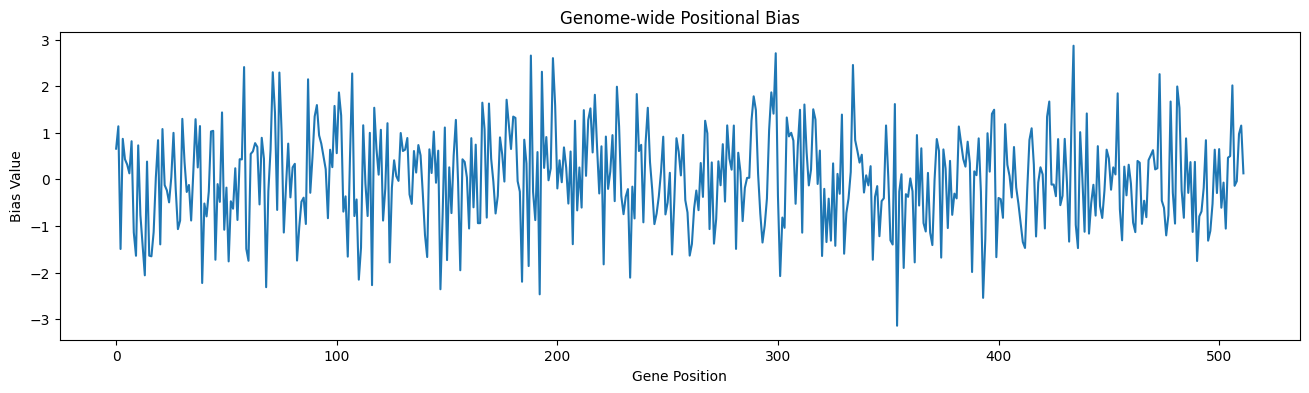

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(position_bias.detach().cpu().numpy())
plt.xlabel("Gene Position")
plt.ylabel("Bias Value")
plt.title("Genome-wide Positional Bias")